# **Simulation Hedy 2024**

Team: TU Wien Space Team \
Project: Lamarr \
Rocket: Hedy \


## Installs

In this section all needed libraries are installed and the needed classes imported

In [28]:
!pip install "netCDF4<1.6.0"

Defaulting to user installation because normal site-packages is not writeable
  Using cached netCDF4-1.5.8.tar.gz (767 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      reading from setup.cfg...
      Package hdf5 was not found in the pkg-config search path.
      Perhaps you should add the directory containing `hdf5.pc'
      to the PKG_CONFIG_PATH environment variable
      Package 'hdf5' not found
      
          HDF5_DIR environment variable not set, checking some standard locations ..
      checking /home/diego/include ...
      hdf5 headers not found in /home/diego/include
      checking /usr/local/include ...
      hdf5 headers not found in /usr/local/include
      checking /sw/include ...
      hdf5 headers not found in /sw/include
      checking /opt/include ...
      hdf5 headers not found in /opt/include
      checking /opt/local/incl

In [29]:
pip install rocketpy==1.6.2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install CoolProp

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank, TrapezoidalFins, FreeFormFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
from math import exp
from math import pi
import datetime
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
from rocketpy.mathutils import Function

## Configuration

The length unit chosen here is millimeters to keep the values more readable. If necessary, values should be converted accordingly.

In [32]:
# Rocket configuration data
env_config = {
    "date" : (2025, 3, 17, 13, 00, 00),   # yyyy, mm, dd, hh, mm, ss
    "latitude" : 39.12368,                # Launch latitude    #Preset
    "longitude" : -8.03333,               # Launch longitude   #Preset
    "timezone" : "Europe/Lisbon"          # GMT+1   #Preset
}
motor_config = {
    "burn_time" : 5.1,                      # s       #calculated
    "holddown_time" : 1.1,                # s       #calculated

    "nitrogen_tank" : {
        "length" : 235.411,               # mm
        "CG_lox" : 2622.95,               # mm
        "CG_ethanol" : 1422.1595,         # mm
        "outer_diameter": 93,             # mm
        "thickness" : 2,                  # mm
        "massflow" : 0.03,                # kg/s   #Estimate
    },
    "ethanol_tank" : {
        "length" : 573.61485,             # mm
        "CG" : 825.55,                    # mm
        "outer_diameter": 115,            # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.5,                 # kg/s   #tested
    },
    "lox_tank" : {
        "length" : 573.978,               # mm
        "CG" : 1932.5205,                 # mm
        "outer_diameter" : 115,           # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.6,                 # kg/s   #tested
    },
    "nozzle" : {
        "diameter" : 75,                  # mm
        "position" : -40,                 # mm
    },


    "use_preset_ethanol_mass" : False,
    "use_preset_lox_mass" : False,
    "use_max_nitrogen_mass" : True,
    "use_max_ethanol_mass" : True,
    "use_max_lox_mass" : True,
    "use_static_thrust": True,
    "thrust": 2000,                       #N
    "overfill_percentage" : 0.001,        # %       #Preset

    "mass" : {
      "ethanol" : 2.7,                    # kg     #Preset
      "lox" : 3.5,                        # kg     #Preset
      "ice" : 0.5                         # kg     #Preset
    },
    "temperature" : {
        "ethanol" : 298.15,               # K      #Preset (= 25°C)
        "lox" : 73.15,                    # K      #Preset (= -200°C)
        "nitrogen" : 298.15             # K      #Preset (= 25°C)
    },
    "pressure" : {
        "ethanol" : 3000000,              # Pa     #Preset
        "lox" : 3000000,                  # Pa     #Preset
        "nitrogen" : 30000000           # Pa     #Preset
    }
}

rocket_config = {
    "account_for_ice" : True,
    "total_weight" : 16580,               # g       #weighed
    "total_length" : 3765,                # mm
    "total_CG" : 1813,                    # mm      #calculated
    "moment_of_intertia_Z" : 0.0255,      # kg*m^2  #calculated
    "moment_of_intertia_XY" : 16.8,       # kg*m^2  #calculated
    "nosecone_length" : 650,              # mm
    "railbuttons" : {
        "upper" : 1646.67,                # mm
        "lower" : 297.5,                  # mm
    },
    "tailcone" : {
        "diameter" : 97.8,                # mm
        "length" : 245.643,               # mm
        "cylindrical_height" : 34.8,      # mm
    },
    "rocket" : {
        "thickness" : 1.4,                # mm
        "diameter" : 132.8,               # mm
    },
    "fins" : {
        "name" : "Biconvex",
        "amount" : 4,
        "root_chord" : 199.0211,          # mm
        "tip_chord" : 79.4,               # mm
        "span" : 96.4,                    # mm
        "sweep_length" : 63.892,          # mm
        "position" : 233,                 # mm
        "shape_points" : ((0,0),
                          (-0.0265,0.0036),
                          (-0.0902,0.114),
                          (-0.170,0.114),
                          (-0.234,0.017),
                          (-0.0265,0.00359),
                          (0,0))
    },
    "parachutes" : {
        "main" : {
            "cd_s" : 6.911503837897546,
            "trigger" : 450,              # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 4,                    # s      #Tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        },
        "drogue" : {
            "cd_s" : 0.336875,
            "trigger" : "apogee",         # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 1,                    # s      #tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        }
    }
}
flight_config = {
    "rail_length" : 11,                   # m       #Preset
    "inclination" : 84,                   # °       #Preset
    "heading" : 133,                      # °       #Preset
}

## Environments Initialization




In this Section the environments are initialized.
*   **envForecast**: environment with the weather data from the wyoming-sounding data source at the location and date of EuRoc
*   **envNormal**: normalized environment with standard atmospheric values at the time and location of EuRoc
*   **envCostom**: custom environment with variable values for temperature and windspeed


In [33]:
#Ponte de Sor: 39.12368, -8.03333
#EUROC: 09.-15.10.2024
#possible launch date: 11.10.2024

#Environment based on Forecast data for the EuRoC 2024
envForecast = Environment()

envForecast.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envForecast.set_elevation("Open-Elevation")
envForecast.set_date(
    env_config["date"],
    timezone = env_config["timezone"]
)

envForecast.set_atmospheric_model(type="Forecast", file="GFS")
envForecast.info()


#Environment based on standard values
envNormal = Environment()
envNormal.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envNormal.set_elevation("Open-Elevation")
envNormal.set_date(env_config["date"], timezone = env_config["timezone"])
envNormal.set_atmospheric_model(type = "standard_atmosphere")
envNormal.info()

#Environment based on Custom Data
envCustom = Environment()
envCustom.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envCustom.set_atmospheric_model(type = "custom_atmosphere", temperature = 30 + 273.15, wind_u = lambda t:10 + (t /1000)**2, wind_v = 0)
envCustom.info()

Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...


RuntimeError: Unable to reach Open-Elevation API servers.

## Simulation

### Tanks / Engine



Nozzle Details
Nozzle Radius: 0.0375 m

Motor Details
Total Burning Time: 6.938321430076018 s
Total Propellant Mass: 9.835 kg
Structural Mass Ratio: 0.000
Average Propellant Exhaust Velocity: 1818.182 m/s
Average Thrust: 2000.000 N
Maximum Thrust: 2000.0 N at 0.0 s after ignition.
Total Impulse: 13876.643 Ns



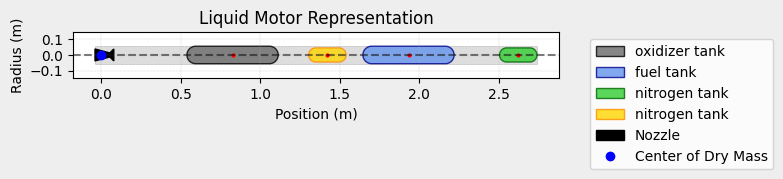

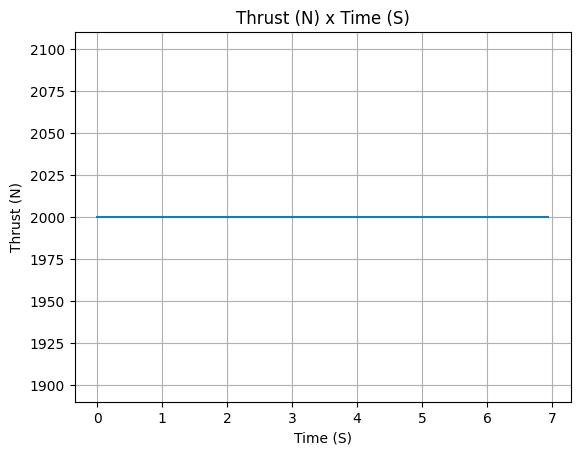

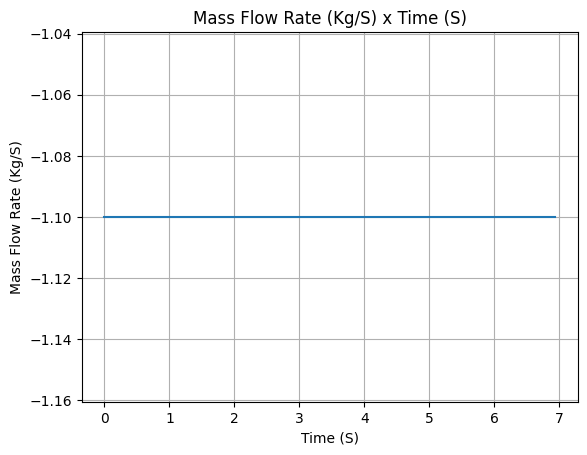

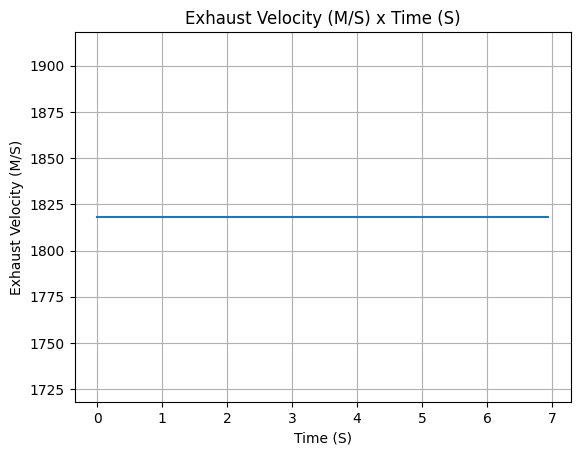

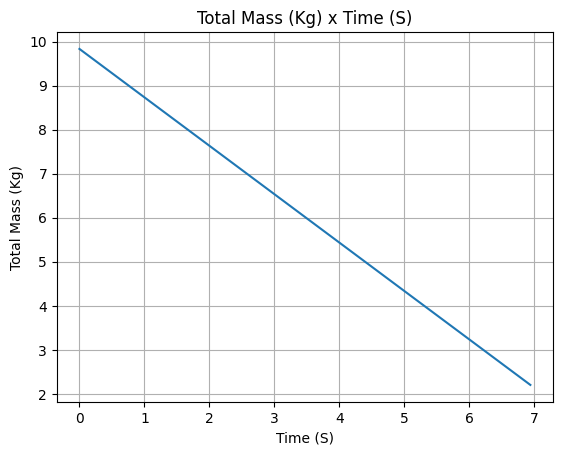

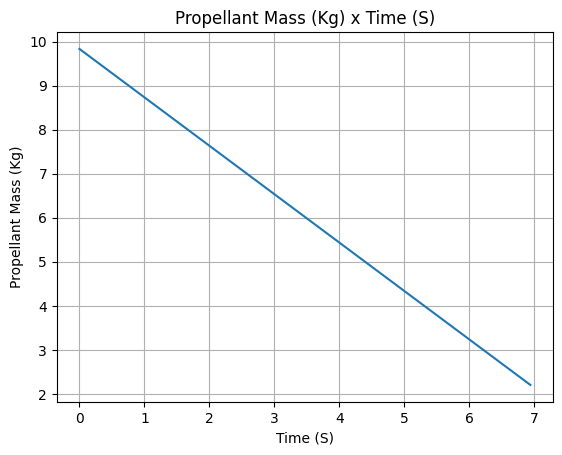

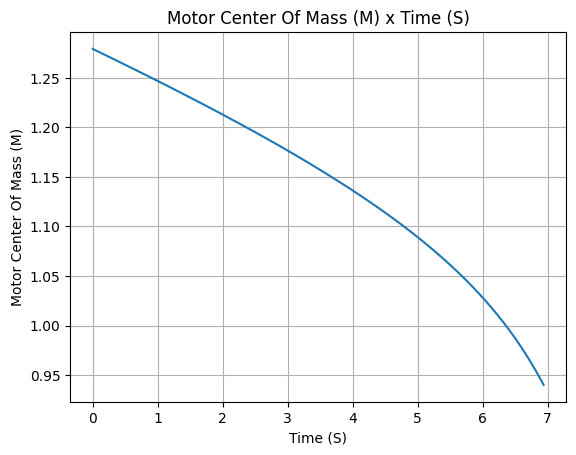

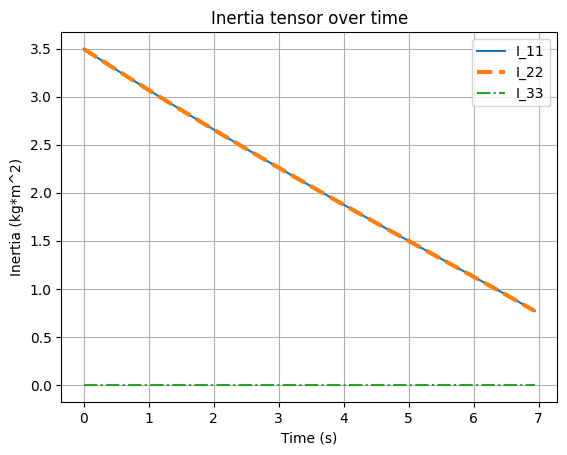

In [ ]:
#Burn time
t_burn              = motor_config["burn_time"]       #s
#holddown time
t_holddown          = motor_config["holddown_time"]   #s


# tank height
h_nitrogen_tank     = motor_config["nitrogen_tank"]["length"]     / 1000  #m
h_ethanol_tank      = motor_config["ethanol_tank"]["length"]      / 1000  #m
h_lox_tank          = motor_config["lox_tank"]["length"]          / 1000  #m
#OuterDiameter
OD_nitrogen_tank    = motor_config["nitrogen_tank"]["outer_diameter"]   / 1000  #m
OD_ethanol_tank     = motor_config["ethanol_tank"]["outer_diameter"]    / 1000  #m
OD_lox_tank         = motor_config["lox_tank"]["outer_diameter"]        / 1000  #m
#Thickness
Th_nitrogen_tank    = motor_config["nitrogen_tank"]["thickness"]  / 1000  #m
Th_ethanol_tank     = motor_config["ethanol_tank"]["thickness"]   / 1000  #m
Th_lox_tank         = motor_config["lox_tank"]["thickness"]       / 1000  #m
#massflows
mdot_nitrogen     = motor_config["nitrogen_tank"] ["massflow"]    #kg/s
mdot_ethanol      = motor_config["ethanol_tank"]["massflow"]      #kg/s
mdot_lox          = motor_config["lox_tank"]["massflow"]          #kg/s
#nozzle
nozzle_diameter     = motor_config["nozzle"]["diameter"]          / 1000  #m
nozzle_position     = motor_config["nozzle"]["position"]          / 1000  #m


#preset mass flag
use_preset_ethanol_mass   = motor_config["use_preset_ethanol_mass"]
use_preset_lox_mass       = motor_config["use_preset_lox_mass"]
#max mass flag
use_max_nitrogen_mass   = motor_config["use_max_nitrogen_mass"]
use_max_ethanol_mass    = motor_config["use_max_ethanol_mass"]
use_max_lox_mass        = motor_config["use_max_lox_mass"]
#static thrust flag
use_static_thrust   = motor_config["use_static_thrust"]
#thrust
thrust              = motor_config["thrust"]                          #N
#Overfill
overfill_percentage = motor_config["overfill_percentage"]             #%


#masses
m_ethanol_preset    = motor_config["mass"]["ethanol"]                 #kg
m_lox_preset        = motor_config["mass"]["lox"]                     #kg
# Temperature Lox & Ethanol
T_nitrogen        = motor_config["temperature"]["nitrogen"]           #K  (=25°C)
T_ethanol         = motor_config["temperature"]["ethanol"]            #K  (=25°C)
T_lox             = motor_config["temperature"]["lox"]                #K
# pressure LOX & Ethanol
p_nitrogen        = motor_config["pressure"]["nitrogen"]              #Pa
p_ethanol         = motor_config["pressure"]["ethanol"]               #Pa
p_lox             = motor_config["pressure"]["lox"]                   #Pa









# inner diameter
ID_nitrogen_tank = OD_nitrogen_tank - (2* Th_nitrogen_tank)     # m
ID_ethanol_tank = OD_ethanol_tank - (2 * Th_ethanol_tank)       # m
ID_lox_tank = OD_lox_tank - (2 * Th_lox_tank)                   # m

# Propellants
# mass
m_nitrogen_calculated = mdot_nitrogen * (t_burn)                # kg
m_ethanol_calculated = mdot_ethanol * (t_burn)                  # kg
m_lox_calculated = mdot_lox * (t_burn)                          # kg

# define density
rho_nitrogen = CP.PropsSI("D","T",T_nitrogen,"P|gas",p_nitrogen,"N2")             # kg/m^3
rho_ethanol = CP.PropsSI("D", "T|liquid", T_ethanol, "P", p_ethanol, "ethanol")   # kg/m^3
rho_lox = CP.PropsSI("D", "T|liquid", T_lox, "P", p_lox, "oxygen")                # kg/m^3

# define fluids
nitrogen = Fluid(name = "N2", density = rho_nitrogen)
ethanol = Fluid(name = "ethanol", density = rho_ethanol)
lox = Fluid(name = "LOX", density = rho_lox)

# define tanks geometry
nitrogen_tank_shape = CylindricalTank(radius = ID_nitrogen_tank / 2, height = h_nitrogen_tank, spherical_caps = True)
ethanol_tank_shape = CylindricalTank(radius = ID_ethanol_tank / 2, height = h_ethanol_tank, spherical_caps = True)
lox_tank_shape = CylindricalTank(radius = ID_lox_tank / 2, height = h_lox_tank, spherical_caps = True)




v_nitrogen_tank = nitrogen_tank_shape.volume(h_nitrogen_tank/2)   # m³
v_ethanol_tank = ethanol_tank_shape.volume(h_ethanol_tank/2)      # m³
v_lox_tank = lox_tank_shape.volume(h_lox_tank/2)                  # m³

m_nitrogen_max = v_nitrogen_tank * rho_nitrogen                   # m
m_ethanol_max = v_ethanol_tank * rho_ethanol                      # m
m_lox_max = v_lox_tank * rho_lox                                  # m

t_burn_nitrogen = (m_nitrogen_max / mdot_nitrogen)-0.001          # s


if(use_max_ethanol_mass and use_preset_ethanol_mass):
  print("Cannot use preset and max!")
  m_enthanol = 100/0

if(use_max_lox_mass and use_preset_lox_mass):
  print("Cannot use preset and max!")
  m_lox = 100/0



if(use_max_nitrogen_mass):
  m_nitrogen = m_nitrogen_max
else:
  m_nitrogen = m_nitrogen_calculated + (overfill_percentage/100 * t_burn * mdot_nitrogen)

if(use_preset_ethanol_mass):
  m_ethanol = m_ethanol_preset
elif(use_max_ethanol_mass):
  m_ethanol = m_ethanol_max
else:
  m_ethanol = m_ethanol_calculated + (overfill_percentage/100 * t_burn * mdot_ethanol)

if(use_preset_lox_mass):
  m_lox = m_lox_preset
elif(use_max_lox_mass):
  m_lox = m_lox_max
else:
  m_lox = m_lox_calculated + (overfill_percentage/100 * t_burn * mdot_lox)

if(use_max_ethanol_mass and use_max_lox_mass):
  t_burn_ethanol = (m_ethanol_max / mdot_ethanol)
  t_burn_lox = (m_lox_max / mdot_lox)
  if(t_burn_ethanol<t_burn_lox):
    t_burn = t_burn_ethanol-0.001
  else:
    t_burn = t_burn_lox-0.001

if(use_static_thrust):
  thrust_curve = lambda t: thrust
else:
  thrust_curve = "thrust_curve.csv"

#account for holddown
t_burn -= t_holddown
m_lox -= mdot_lox * t_holddown
m_ethanol -= mdot_ethanol * t_holddown

if(t_burn_nitrogen<t_burn):
  print("WARNING: TOO LITTLE NITROGEN, UNKNOWN EFFECTS")


# define tanks
nitrogen_tank = MassFlowRateBasedTank(
    name = "nitrogen tank",
    geometry = nitrogen_tank_shape,
    flux_time = t_burn_nitrogen,                        # s
    initial_liquid_mass = 0,                            # kg
    initial_gas_mass = m_nitrogen,                      # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = 0,                      # kg/s
    gas_mass_flow_rate_in = 0,                          # kg/s
    gas_mass_flow_rate_out = lambda t: mdot_nitrogen,   # ks/s
    liquid = Fluid(name = "liquid", density = 0.0001),  # ignore
    gas = nitrogen,
)
ethanol_tank = MassFlowRateBasedTank(
    name = "fuel tank",
    geometry = ethanol_tank_shape,
    flux_time = t_burn,                                 # s
    initial_liquid_mass = m_ethanol,                    # kg
    initial_gas_mass = 0,                               # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = lambda t: mdot_ethanol, # kg/s
    gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
    gas_mass_flow_rate_out = 0,                         # kg/s
    liquid = ethanol,
    gas = nitrogen,
)

lox_tank = MassFlowRateBasedTank(
    name = "oxidizer tank",
    geometry = lox_tank_shape,
    flux_time = t_burn,                                 # s
    initial_liquid_mass = m_lox,                        # kg
    initial_gas_mass = 0,                               # kg
    liquid_mass_flow_rate_in = 0,                       # kg/s
    liquid_mass_flow_rate_out = lambda t: mdot_lox,     # kg/s
    gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
    gas_mass_flow_rate_out = 0,                         # kg/s
    liquid = lox,
    gas = nitrogen,
)

skuld = LiquidMotor(
    dry_mass = 0.0001,                  # kg
    dry_inertia = (0,0,0),              # kg*m^2
    center_of_dry_mass_position = 0,    # m

    nozzle_radius = nozzle_diameter /2, # m
    nozzle_position = nozzle_position,  # m

    thrust_source = thrust_curve,       # N
    burn_time = t_burn,                 # s
    coordinate_system_orientation = "nozzle_to_combustion_chamber"
)

skuld.add_tank(tank = lox_tank, position =        motor_config["ethanol_tank"]["CG"]                /1000)
skuld.add_tank(tank = ethanol_tank, position =    motor_config["lox_tank"]["CG"]            /1000)
skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_lox"]       /1000)
skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_ethanol"]   /1000)

skuld.all_info()

### Rocket components

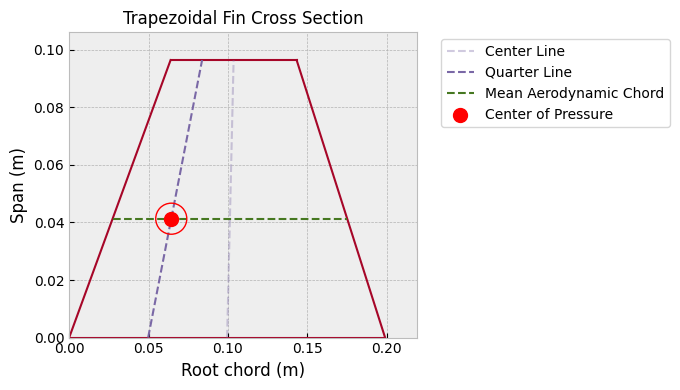

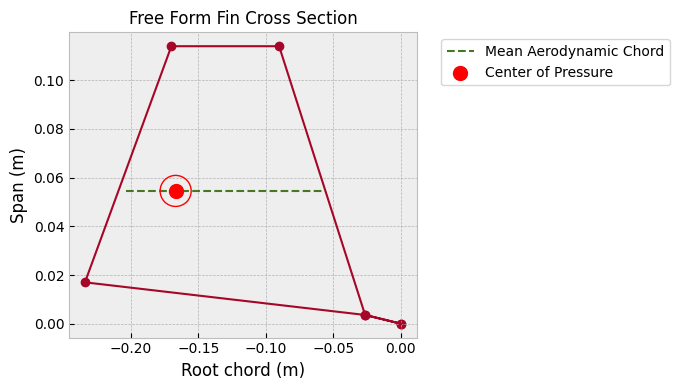

In [ ]:
#rocket
rocket_length     = rocket_config["total_length"]         / 1000  #m
rocket_diameter   = rocket_config["rocket"]["diameter"]   / 1000  #m
rocket_thickness  = rocket_config["rocket"]["thickness"]  / 1000  #m

nose_cone = NoseCone(
    length = (rocket_config["nosecone_length"]-100)/1000, # m
    base_radius = rocket_diameter/2,                      # m
    kind = "lv haack"
)

tailcone_cylindrical    = rocket_config["tailcone"]["cylindrical_height"] / 1000 # m
tailcone_length         = rocket_config["tailcone"]["length"]             / 1000 # m
tailcone_bottom_radius  = rocket_config["tailcone"]["diameter"]        /2 / 1000 # m

tail = Tail(
    top_radius = rocket_diameter /2,        # m
    bottom_radius = tailcone_bottom_radius, # m
    length = tailcone_length,               # m
    rocket_radius = rocket_diameter/2       # m
)

fin_amount        = rocket_config["fins"]["amount"]
fin_name          = rocket_config["fins"]["name"]
fin_position      = rocket_config["fins"]["position"]     / 1000  # m
fin_root_chord    = rocket_config["fins"]["root_chord"]   / 1000  # m
fin_tip_chord     = rocket_config["fins"]["tip_chord"]    / 1000  # m
fin_span          = rocket_config["fins"]["span"]         / 1000  # m
fin_sweep_length  = rocket_config["fins"]["sweep_length"] / 1000  # m
fin_shape_points  = rocket_config["fins"]["shape_points"]

trapezoidal_fin_set = TrapezoidalFins(
    n = fin_amount,
    root_chord = fin_root_chord,      # m
    tip_chord = fin_tip_chord,        # m
    span = fin_span,                  # m
    sweep_length = fin_sweep_length,  # m
    #cant_angle = fin_cant_angle,     # deg
    #sweep_angle = fin_sweep_angle,   # deg
    name = fin_name,
    rocket_radius = rocket_diameter/2 # m
  )
trapezoidal_fin_set.draw()

fin_set = FreeFormFins(
   n = fin_amount,
   shape_points = fin_shape_points,
   rocket_radius=tailcone_bottom_radius,
   name = "Freeform"
)
fin_set.draw()

parachutes = {}

parachutes[0] = Parachute(
    name = "main",
    cd_s = rocket_config["parachutes"]["main"]["cd_s"],
    trigger = rocket_config["parachutes"]["main"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["main"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["main"]["lag"],                     # s
    noise = rocket_config["parachutes"]["main"]["noise"],                 # (pa, pa, pa)
)

parachutes[1] = Parachute(
    name = "drogue",
    cd_s = rocket_config["parachutes"]["drogue"]["cd_s"],
    trigger = rocket_config["parachutes"]["drogue"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["drogue"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["drogue"]["lag"],                     # s
    noise = rocket_config["parachutes"]["drogue"]["noise"],                 # (pa, pa, pa)
)

### Hedy


Inertia Details

Rocket Mass: 17.080 kg (without motor)
Rocket Dry Mass: 17.080 kg (with unloaded motor)
Rocket Loaded Mass: 26.915 kg
Rocket Structural Mass Ratio: 0.635
Rocket Inertia (with unloaded motor) 11: 16.800 kg*m2
Rocket Inertia (with unloaded motor) 22: 16.800 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.025 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0664 m
Rocket Frontal Area: 0.013851 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit: 1.853 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.534 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.195 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Freeform Lift Coefficient Derivative: 6.377/rad
Tail Lift Coeffici

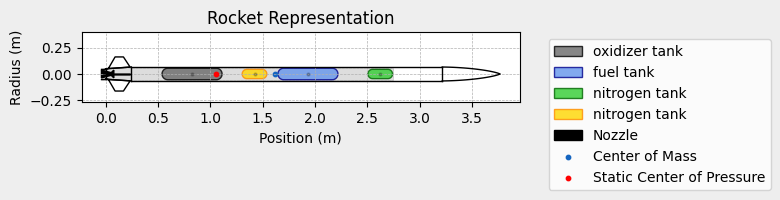


Mass Plots
----------------------------------------


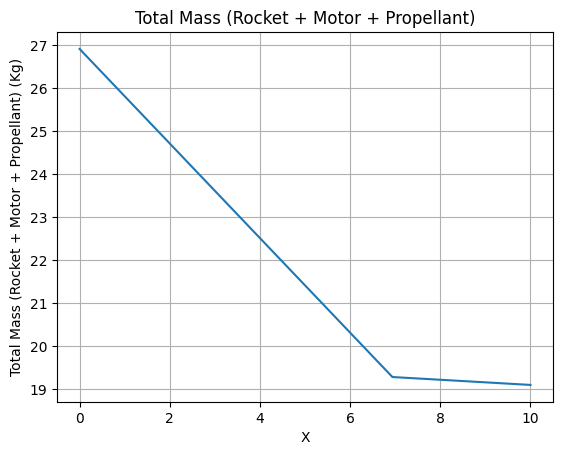

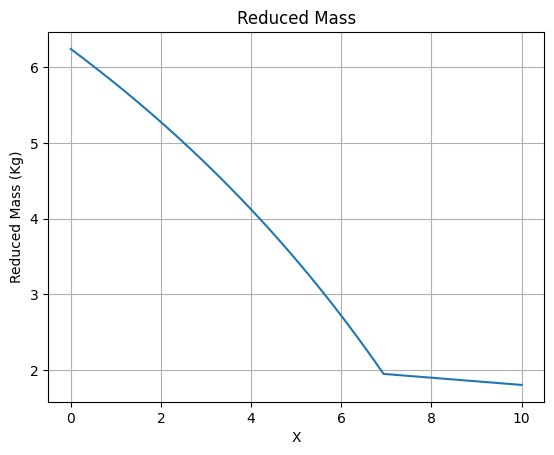


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


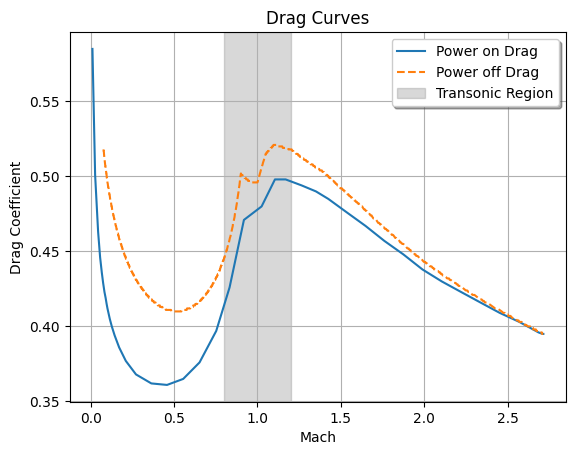


Stability Plots
--------------------


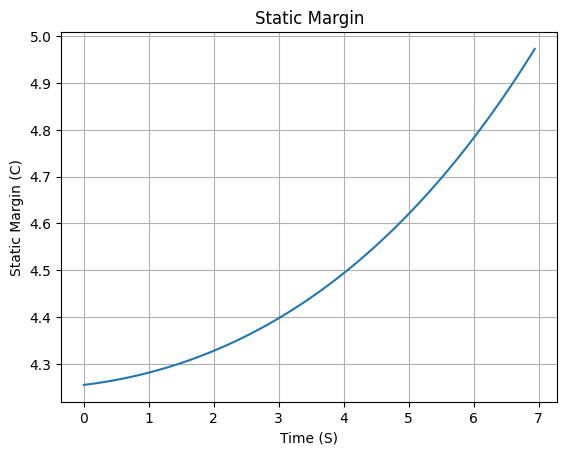

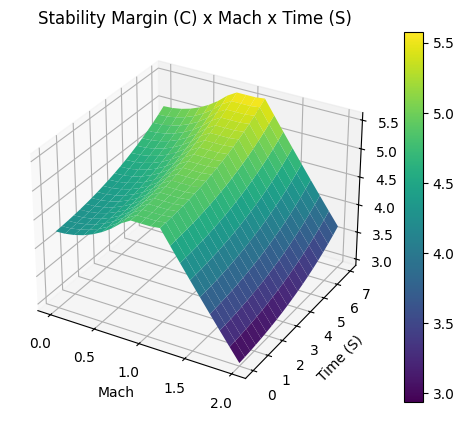


Thrust-to-Weight Plot
----------------------------------------


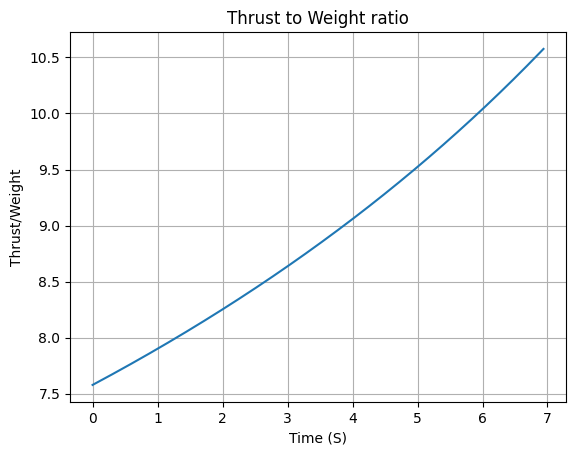

In [ ]:

total_mass        = rocket_config["total_weight"]         / 1000  # kg

if rocket_config["account_for_ice"]:
  total_mass += motor_config["mass"]["ice"]

#inertia
inertia_x_y   = rocket_config["moment_of_intertia_XY"]          # kg/m^2
inertia_z     = rocket_config["moment_of_intertia_Z"]           # kg/m^2

upper_railbutton_position = rocket_config["railbuttons"]["upper"]/1000
lower_railbutton_position = rocket_config["railbuttons"]["lower"]/1000

#CG
CG                = rocket_config["total_CG"]             / 1000  # m

hedy = Rocket(
    radius = rocket_diameter /2,                      # m
    mass = total_mass,                                # m
    inertia = (inertia_x_y, inertia_x_y, inertia_z),  # kg * m^2
    power_off_drag = "../power_off_drag.csv",
    power_on_drag = "../power_on_drag.csv",
    center_of_mass_without_motor = CG,                # m
    coordinate_system_orientation = "tail_to_nose"
)
hedy.add_motor(skuld, position = 0)


#hedy.set_rail_buttons(upper_button_position= upper_railbutton_position, lower_button_position=lower_railbutton_position)

hedy.add_surfaces(surfaces=[nose_cone, fin_set, tail], positions=[rocket_length, 0, tailcone_length])

hedy.parachutes = list(parachutes.values())

hedy.all_info()

### Flight

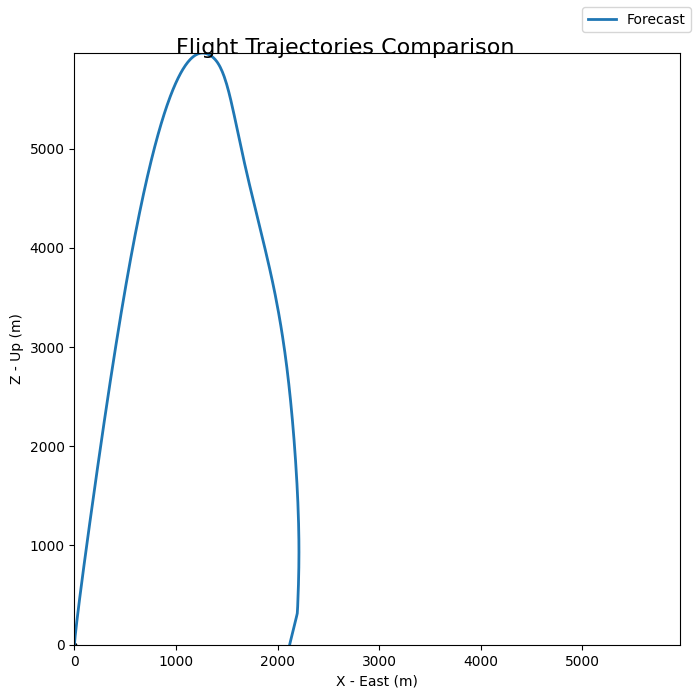

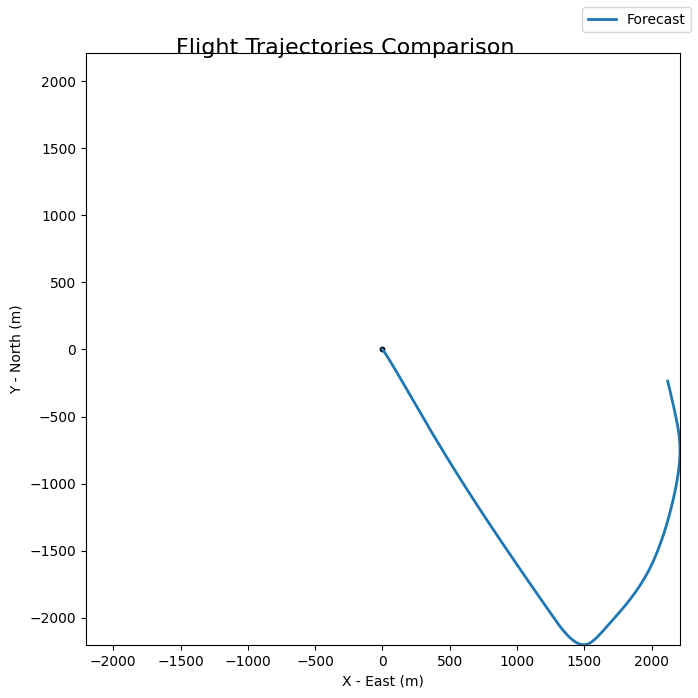

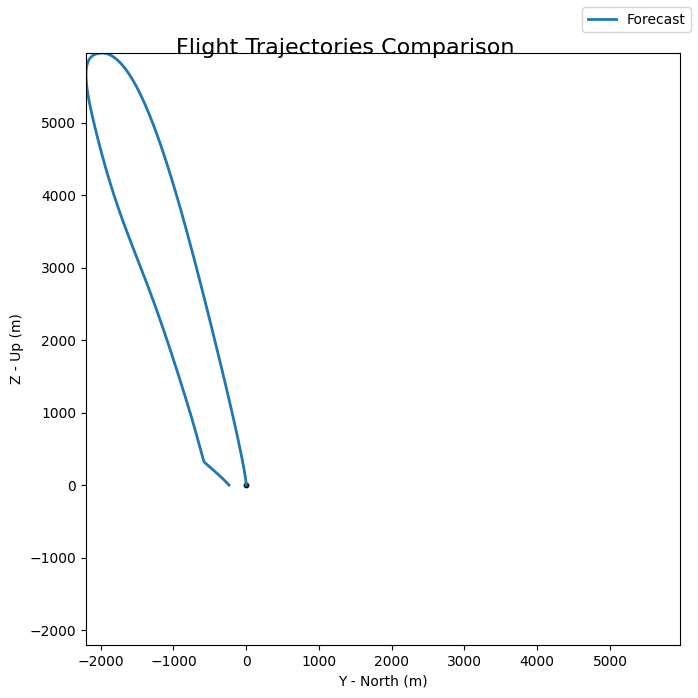

In [ ]:
from os import name
from rocketpy import CompareFlights

flight = Flight(
          environment = envNormal,
          rocket = hedy,
          rail_length =   flight_config["rail_length"], # m
          inclination =   flight_config["inclination"], # °
          heading =       flight_config["heading"],     # °
          terminate_on_apogee = False,
          name = "Normal"
 )
#flight.prints.out_of_rail_conditions()
#flight.prints.apogee_conditions()
#flight.prints.impact_conditions()
#flight.prints.maximum_values()
#flight.plots.trajectory_3d()
#flight.plots.stability_and_control_data()
#flight.plots.all()

#flight.prints.all()
#flight.all_info()



flight_forecast = Flight(
          environment = envForecast,
          rocket = hedy,
          rail_length =   flight_config["rail_length"], # m
          inclination =   flight_config["inclination"], # °
          heading =       flight_config["heading"],     # °
          name = "Forecast"
  )
#flight_forecast.prints.out_of_rail_conditions()
#flight_forecast.prints.apogee_conditions()
#flight_forecast.prints.impact_conditions()
#flight_forecast.prints.maximum_values()
#flight_forecast.plots.trajectory_3d()
#flight_forecast.plots.stability_and_control_data()
#flight_forecast.all_info()

flights = []
flights.append(flight_forecast)

comparison = CompareFlights(flights)
comparison.trajectories_2d(plane = 'xz', legend = True)
comparison.trajectories_2d(plane = 'xy', legend = True)
comparison.trajectories_2d(plane = 'yz', legend = True)


In [46]:
alt = Function(flight_forecast.altitude)
lat = Function(flight_forecast.latitude)
lon = Function(flight_forecast.longitude)

print(alt.source)
print(lat.source)
print(lon.source)

alt.savetxt("alt.csv")
lat.savetxt("lat.csv")
lon.savetxt("lon.csv")

[[ 0.00000000e+00  0.00000000e+00]
 [ 5.00258226e-03  1.60759306e-03]
 [ 1.00051645e-02  4.82315500e-03]
 ...
 [ 2.53162243e+02  2.27931970e+01]
 [ 2.56030058e+02  4.55274383e+00]
 [ 2.56746208e+02 -9.66924796e-06]]
[[0.00000000e+00 3.91236800e+01]
 [5.00258226e-03 3.91236800e+01]
 [1.00051645e-02 3.91236800e+01]
 ...
 [2.53162243e+02 3.91213679e+01]
 [2.56030058e+02 3.91215179e+01]
 [2.56746208e+02 3.91215546e+01]]
[[ 0.00000000e+00 -8.03333000e+00]
 [ 5.00258226e-03 -8.03333000e+00]
 [ 1.00051645e-02 -8.03333000e+00]
 ...
 [ 2.53162243e+02 -8.00873175e+00]
 [ 2.56030058e+02 -8.00877829e+00]
 [ 2.56746208e+02 -8.00878973e+00]]


Only one motor per rocket is currently supported. Overwriting previous motor.

Apogee State

Apogee Time: 35.086 s
Apogee Altitude: 6484.291 m (ASL) | 6326.252 m (AGL)
Apogee Freestream Speed: 19.122 m/s
Apogee X position: 158.544 m
Apogee Y position: 317.765 m
Apogee latitude: 39.1265345°
Apogee longitude: -8.0314941°


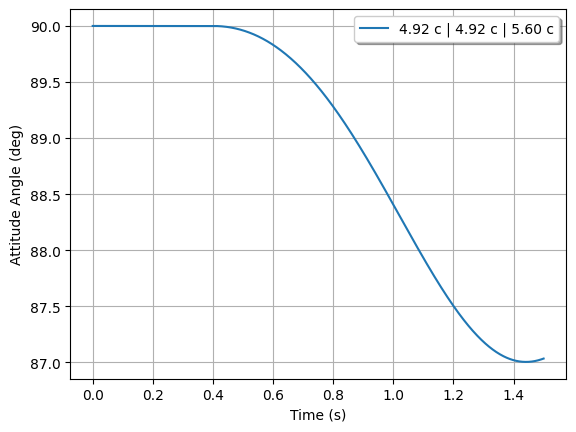

In [23]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
hedy2 = copy.deepcopy(hedy)
hedy2.motor.positioned_tanks.pop(-4)
hedy2.motor.positioned_tanks.pop(-3)



# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.7]:
    # Modify rocket fin set by removing previous one and adding new one

    lox_tank2 = lox_tank
    lox_tank2.liquid_mass_flow_rate_out = 0.3

    ethanol_tank2 = ethanol_tank
    ethanol_tank2.liquid_mass_flow_rate_out = 0.3
    skuld2 = LiquidMotor(
        dry_mass = skuld.dry_mass,                  # kg
        dry_inertia = (skuld.dry_I_11, skuld.dry_I_22, skuld.dry_I_33),              # kg*m^2
        center_of_dry_mass_position = skuld.center_of_dry_mass_position,    # m

        nozzle_radius = skuld.nozzle_radius, # m
        nozzle_position = skuld.nozzle_position,  # m

        thrust_source = skuld.thrust_source,       # N
        burn_time = skuld.burn_time,                 # s
        coordinate_system_orientation = skuld.coordinate_system_orientation
    )
    skuld2.add_tank(tank = lox_tank2,   	position =   motor_config["lox_tank"]["CG"]                /1000)
    skuld2.add_tank(tank = ethanol_tank2, position =   motor_config["ethanol_tank"]["CG"]            /1000)
    skuld2.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_lox"]       /1000)
    skuld2.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_ethanol"]   /1000)

    hedy2.add_motor(skuld2, position = 0)
    # Simulate
    test_flight = Flight(
        rocket=hedy2,
        environment=envForecast,
        rail_length=5.2,
        inclination=90,
        heading=0
    )

    test_flight.prints.apogee_conditions()
    # Store Results
    static_margin_at_ignition = hedy2.static_margin(0)
    static_margin_at_out_of_rail = hedy2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = hedy2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

# Switch Tanks

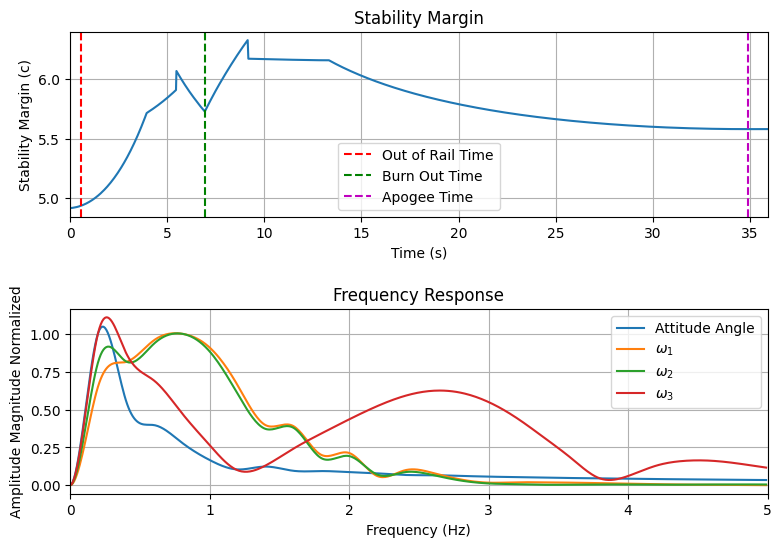

In [ ]:

flight_forecast.plots.stability_and_control_data() Ethanol unten

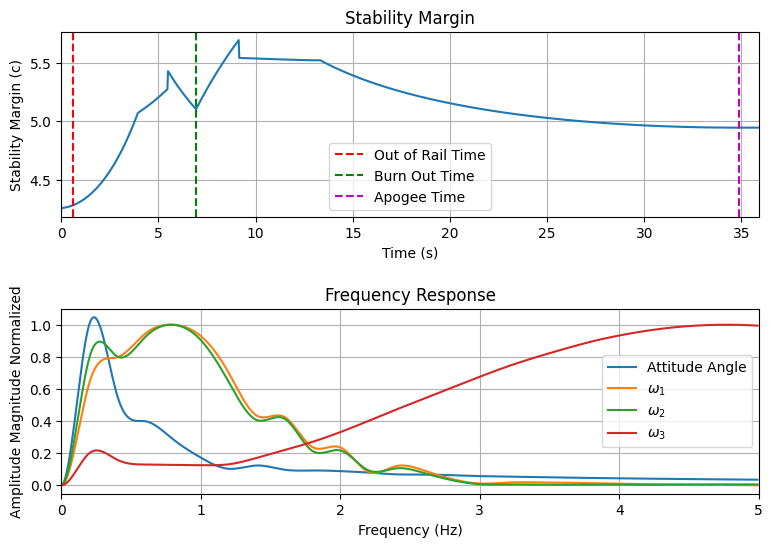

In [ ]:

flight_forecast.plots.stability_and_control_data() Ethanol oben

# **Stochastic Calculations (Monte Carlo)**


## Imports

In [ ]:
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticSolidMotor,
    StochasticRocket,
    StochasticFlight,
    StochasticNoseCone,
    StochasticTail,
    StochasticTrapezoidalFins,
    StochasticParachute,
    StochasticRailButtons,
)
from rocketpy import MonteCarlo
from rocketpy import Components

## Stochastic environment

In [ ]:
envEnsemble = Environment()
envEnsemble.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envEnsemble.set_elevation("Open-Elevation")
envEnsemble.set_date((env_config["date"]), timezone= env_config["timezone"]) #Latest available date at time of simualtion
envEnsemble.set_atmospheric_model(type = "Ensemble", file = "GEFS")


stochastic_env = StochasticEnvironment(
    environment = envEnsemble,
    wind_velocity_x_factor = (0, 10, "normal"),
    wind_velocity_y_factor = (0, 10, "normal"),

    ensemble_member = list(range(envEnsemble.num_ensemble_members)),
)
stochastic_env.visualize_attributes()

Fetching elevation from open-elevation.com for lat=39.12368, lon=-8.03333...
Elevation received: 161.0 m


/usr/local/lib/python3.10/dist-packages/rocketpy/environment/tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2024-10-11 12:00:00 UTC instead.
  warnings.warn(


Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                161.0
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.12368
	longitude                -8.03333
	timezone                 Europe/Lisbon

Stochastic Attributes:
	wind_velocity_x_factor   0.00000 ± 10.00000 (normal)
	wind_velocity_y_factor   0.00000 ± 10.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


## Approximating the liquid motor

In [ ]:
grain_outer_radius = 0.05  # m
grain_inner_radius = 0.01  # m
grain_height = 0.1         # m

approx_motor = SolidMotor(
    thrust_source = skuld.thrust_source,
    burn_time = skuld.burn_time,          # s
    center_of_dry_mass_position = 0,      # m
    dry_mass = skuld.dry_mass,            # kg
    dry_inertia = [0, 0, 0],              # kg * m^2
    grains_center_of_mass_position = CG,  # m
    grain_number = 1,
    grain_density = (lox_tank.fluid_mass(0) + ethanol_tank.fluid_mass(0)) / (((grain_outer_radius**2) * pi * grain_height) - ((grain_inner_radius**2) * pi * grain_height)), # kg / m^3
    grain_outer_radius = grain_outer_radius,         # m
    grain_initial_inner_radius = grain_inner_radius, # m
    grain_initial_height = grain_height,             # m
    grain_separation = 0,                     # m
    nozzle_radius = skuld.nozzle_radius,      # m
    nozzle_position = skuld.nozzle_position,  # m
    throat_radius = skuld.nozzle_radius,      # m
    reshape_thrust_curve = False,
    coordinate_system_orientation = 'nozzle_to_combustion_chamber',
)
#approx_motor.all_info()

## Stochastic rocket

In [ ]:
railbuttons = RailButtons(
    buttons_distance = upper_railbutton_position-lower_railbutton_position
)

In [ ]:
hedy.aerodynamic_surfaces = Components()
hedy.add_surfaces(surfaces=[nose_cone, trapezoidal_fin_set, tail], positions=[rocket_length, fin_position, tailcone_length])

stochastic_rocket = StochasticRocket(
    rocket = hedy,
)

stochastic_nose_cone = StochasticNoseCone(
    nosecone = nose_cone
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins = trapezoidal_fin_set,
)

stochastic_tail = StochasticTail(
    tail = tail
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons = railbuttons
)

stochastic_main = StochasticParachute(
    parachute = parachutes[0]
)

stochastic_drogue = StochasticParachute(
    parachute = parachutes[1]
)

stochastic_motor = StochasticSolidMotor(
    solid_motor = approx_motor
)

stochastic_rocket.add_nose(stochastic_nose_cone)
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set)
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)
stochastic_rocket.add_motor(stochastic_motor)

stochastic_rocket.visualize_attributes()


stochastic_flight = StochasticFlight(
    flight = flight,
    inclination=(flight_config["inclination"], 1),
    heading=(flight_config["heading"], 2)
)

stochastic_flight.visualize_attributes()



test_dispersion = MonteCarlo(
    filename = "monte_carlo_class_example",
    environment = stochastic_env,
    rocket = stochastic_rocket,
    flight = stochastic_flight
)

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_11_without_motor              16.8
	I_12_without_motor              0
	I_13_without_motor              0
	I_22_without_motor              16.8
	I_23_without_motor              0
	I_33_without_motor              0.0255
	center_of_mass_without_motor    1.813
	coordinate_system_orientation   tail_to_nose
	mass                            16.22207571
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)
	radius                          0.0664

Stochastic Attributes:
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           11

Stochastic Attributes:
	heading               113.00000 ± 2.0

## Simulation

In [ ]:
test_dispersion.simulate(number_of_simulations = 100, append = False)

print()
print()
print()
print()
print()
print()
print()
print()
print("//////////////////////////////////////////////////")
print("//                 FINISHED                     //")
print("//////////////////////////////////////////////////")

Error on iteration 1: Object of type Vector is not JSON serializable


TypeError: Object of type Vector is not JSON serializable

## Outputs

In [ ]:
print(test_dispersion.num_of_loaded_sims)
test_dispersion.prints.all()
test_dispersion.plots.ellipses(xlim = (-2000, 4000), ylim = (-2000, 4000))